In [1]:
import xarray as xr
import numpy as np
import sys
sys.path.append("/vols/satellite/home/lenk/utils/tracking")
import object_tracking as ot

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage as ndi
from skimage.morphology import h_minima

import load_satellite_data as lsd

import datetime as dt
import pandas as pd

from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap(vmin=210,vmed=240,vmax=300)

import fixed_colourbar as fc

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


NameError: name 'np' is not defined

In [2]:
def get_mask_threshold(field,max_threshold,spread):
    """
    Determine threshold from given field. If the field minimum is lower than the given threshold,
    the threshold to determine the cloud edge is determined using the given spread.
    
    Inputs:
        * field: array-like, 2-dimensional
            numpy array with the field data
        * max_threshold: int or float
            threshold of the cloud edge
        * spread: int or float
            spread to determine cloud edge, if the minimum is lower than the threshold
            
    Returns:
        * threshold: int or float
            derived threshold
    """
    # get minimum of the field
    field_min = np.min(field)
    
    if field_min >= max_threshold:
        return np.nan
    else:
        # determine spread
        spread = np.min((max_threshold-field_min,spread))

        # return threshold
        return np.min((field_min+spread,max_threshold))

In [3]:
def get_mask_threshold2(max_threshold,spread,field=None,object_min=240,):
    """
    Determine threshold from given field or object minimum. If the minimum is lower than the given threshold,
    the threshold to determine the cloud edge is determined using the given spread.
   
    Inputs:
        * max_threshold: int or float
            maximum threshold of the cloud edge
        * spread: int or float
            spread to determine cloud edge, if the minimum is lower than the threshold
        * field: array-like, default=None
            numpy array with the field data
        * object_min: int or float, default=240
            object minimum
    """
        
    if np.all(field) != None:
        # get minimum of the field
        minimum = np.min(field)
    else:
        minimum = object_min
   
    # return threshold
    return np.max((minimum+spread,max_threshold))    

In [4]:
def get_local_minima(field,depth,gauss_sigma):
    """
    Find local minima of a given depth in a given, possibly smoothed field.
    
    Inputs:
        * field: array-like, 2-dimensional
            numpy array of the input field
        * depth: int or float
            depth of the local minima
        * gauss_sigma: int or float
            sigma of the gaussian smoothing
            
    Returns:
        * lm_labeleld: array-like, shape of field
            numpy array with labeled local minima locations
        * labels: array-like, 1-dimensional
            unique minima labels
    """
    # smooth input field
    field_smooth = ndi.gaussian_filter(field,gauss_sigma)
    
    # find local minima of the given depth
    local_mins = h_minima(field_smooth,depth)
    
    # field with labeled local minima
    lm_labeled = ndi.label(local_mins)[0]
    
    # return label field and its unique values
    return lm_labeled, np.unique(lm_labeled)[1:]

In [5]:
def get_values_from_labels(field,label_field,labels):
    """
    Get the values at local minima.
    
    Inputs:
        * label_field: array-like, 2-dimensional
            numpy array with labeled local minima locations
        * labels: list or numpy array, 1-dimensional
            unique values of the labels
            
    Returns:
        * values: dictionary, {label: value}
            dictionary with the minima labels as keys and the corrresponding minimum values
    """
    if not np.any(labels):
        labels = np.unique(label_field)[1:]
        
    values = { l:[] for l in labels}
    
    for l in labels:
        value = np.unique(field[np.where(label_field==l)])
        values[l] = value[0]
        
    return values

In [6]:
def get_threshold(field,label_values,max_threshold,spread):
    """
    Determine threshold from given field. If the field minimum is lower than the given threshold,
    the threshold to determine the cloud edge is determined using the given spread. Wrapper for get_mask_threshold.
    
    Inputs:
        * field: array-like, 2-dimensional
            numpy array of the input field
        * label values: dictionary {label: value}
            dictionary of the labels of local minima and their corresponding values
        * max_threshold: int or float
            maximum threshold to determine object edges
        * spread: int or float
            spread to determine cloud edge, if the minimum is lower than the threshold
            
    Returns:
        * thresholds: dictionary, {label: threshold}
            dictionary with the minima labels as keys and the corrresponding threshold values
    """
    thresholds = { l:{} for l in label_values.keys()}
    
    for l in label_values.keys():
        threshold = get_mask_threshold(np.array([label_values[l]]), max_threshold, spread)
        thresholds[l] = threshold
        
    return thresholds

In [7]:
def segment_local_thresholds(field,label_field,label_thresholds):
    """
    Segment a given field using local minima and individual thresholds for those minima.
    
    Inputs:
        * field: array-like, 2-dimensional
            numpy array of the input field
        * label values: dictionary {label: value}
            dictionary of the labels of local minima and their corresponding values
        * label_thresholds: dictionary, {label: threshold}
            dictionary with the minima labels as keys and the corrresponding threshold values
    Returns:
        * segmented: array-like, shape of field
            numpy array with labeled objects
    """
    # create segmentation dummy to fill
    segmented = np.zeros_like(field,dtype="uint8")
    
    # run through all labels
    for l in label_thresholds.keys():
        if np.isnan(label_thresholds[l]):
            continue
        else:
            # mask areas larger than the threshold
            mask = np.ma.masked_greater(field,label_thresholds[l])
            
            # label the mask
            mask_labeled = ndi.label(~mask.mask*1)[0]
            
            # find the location of the wanted minimum
            lokmin_location = np.where(label_field == l)
            
            # get id of wanted minimum
            wanted_obj_id = mask_labeled[lokmin_location]
            
            # get locations of wanted object
            wanted_obj_location = np.where(mask_labeled==wanted_obj_id)
            
            # save it to the segmentation dummy
            #segmented[wanted_obj_location] = l
            segmented[wanted_obj_location] = 1  

            
    #return segmented
    return ndi.label(segmented)[0]

In [8]:
def segment_local_minima(field,min_depth,max_threshold,spread,gauss_sigma):
    
    lm_labeled, labels = get_local_minima(field,min_depth,gauss_sigma)
    minima_values = get_values_from_labels(field, lm_labeled, labels)
    threshold_values  = get_threshold(field, minima_values, max_threshold, spread)
                
    segmented = segment_local_thresholds(field, lm_labeled, threshold_values)
            
    return segmented

In [4]:
data_folder = "/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/"
sat_data = xr.open_dataset("{}/msg2-20130618-l15msg.nc".format(data_folder))

In [10]:
segmented = []

for i,ir in enumerate(sat_data.ir108.data):
    segmented.append(segment_local_minima(ir,10,280,20,0.2))

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [11]:
test = sat_data.ir108.data[15].copy()

In [12]:
lm_labeled, labels = get_local_minima(test,10,1)
minima_values = get_values_from_labels(test, lm_labeled, labels)
threshold_values  = get_threshold(test, minima_values, 280, 12)

In [13]:
segmented = np.zeros_like(test)

In [14]:
for l in threshold_values.keys():
        if np.isnan(threshold_values[l]):
            continue
        else:
            # mask areas larger than the threshold
            mask = np.ma.masked_greater(test,threshold_values[l])
            
            # label the mask
            mask_labeled = ndi.label(~mask.mask*1)[0]
            
            # find the location of the wanted minimum
            lokmin_location = np.where(lm_labeled == l)
            
            # get id of wanted minimum
            wanted_obj_id = mask_labeled[lokmin_location]
            
            # get locations of wanted object
            wanted_obj_location = np.where(mask_labeled==wanted_obj_id)
            
            # save it to the segmentation dummy
            segmented[wanted_obj_location] = 1  
            
            segmented = ndi.label(segmented)[0]

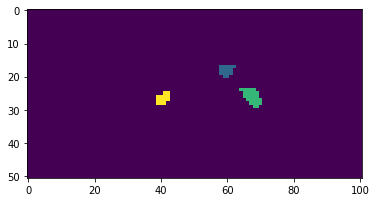

In [15]:
plt.imshow(segmented)

In [16]:
segmented = []

for i,ir in enumerate(sat_data.ir108.data):
    segmented.append(segment_local_minima(ir,10,280,15,1))

In [17]:
cmap = plt.get_cmap('nipy_spectral', 5)

Text(0.5, 1.0, 'Object ID')

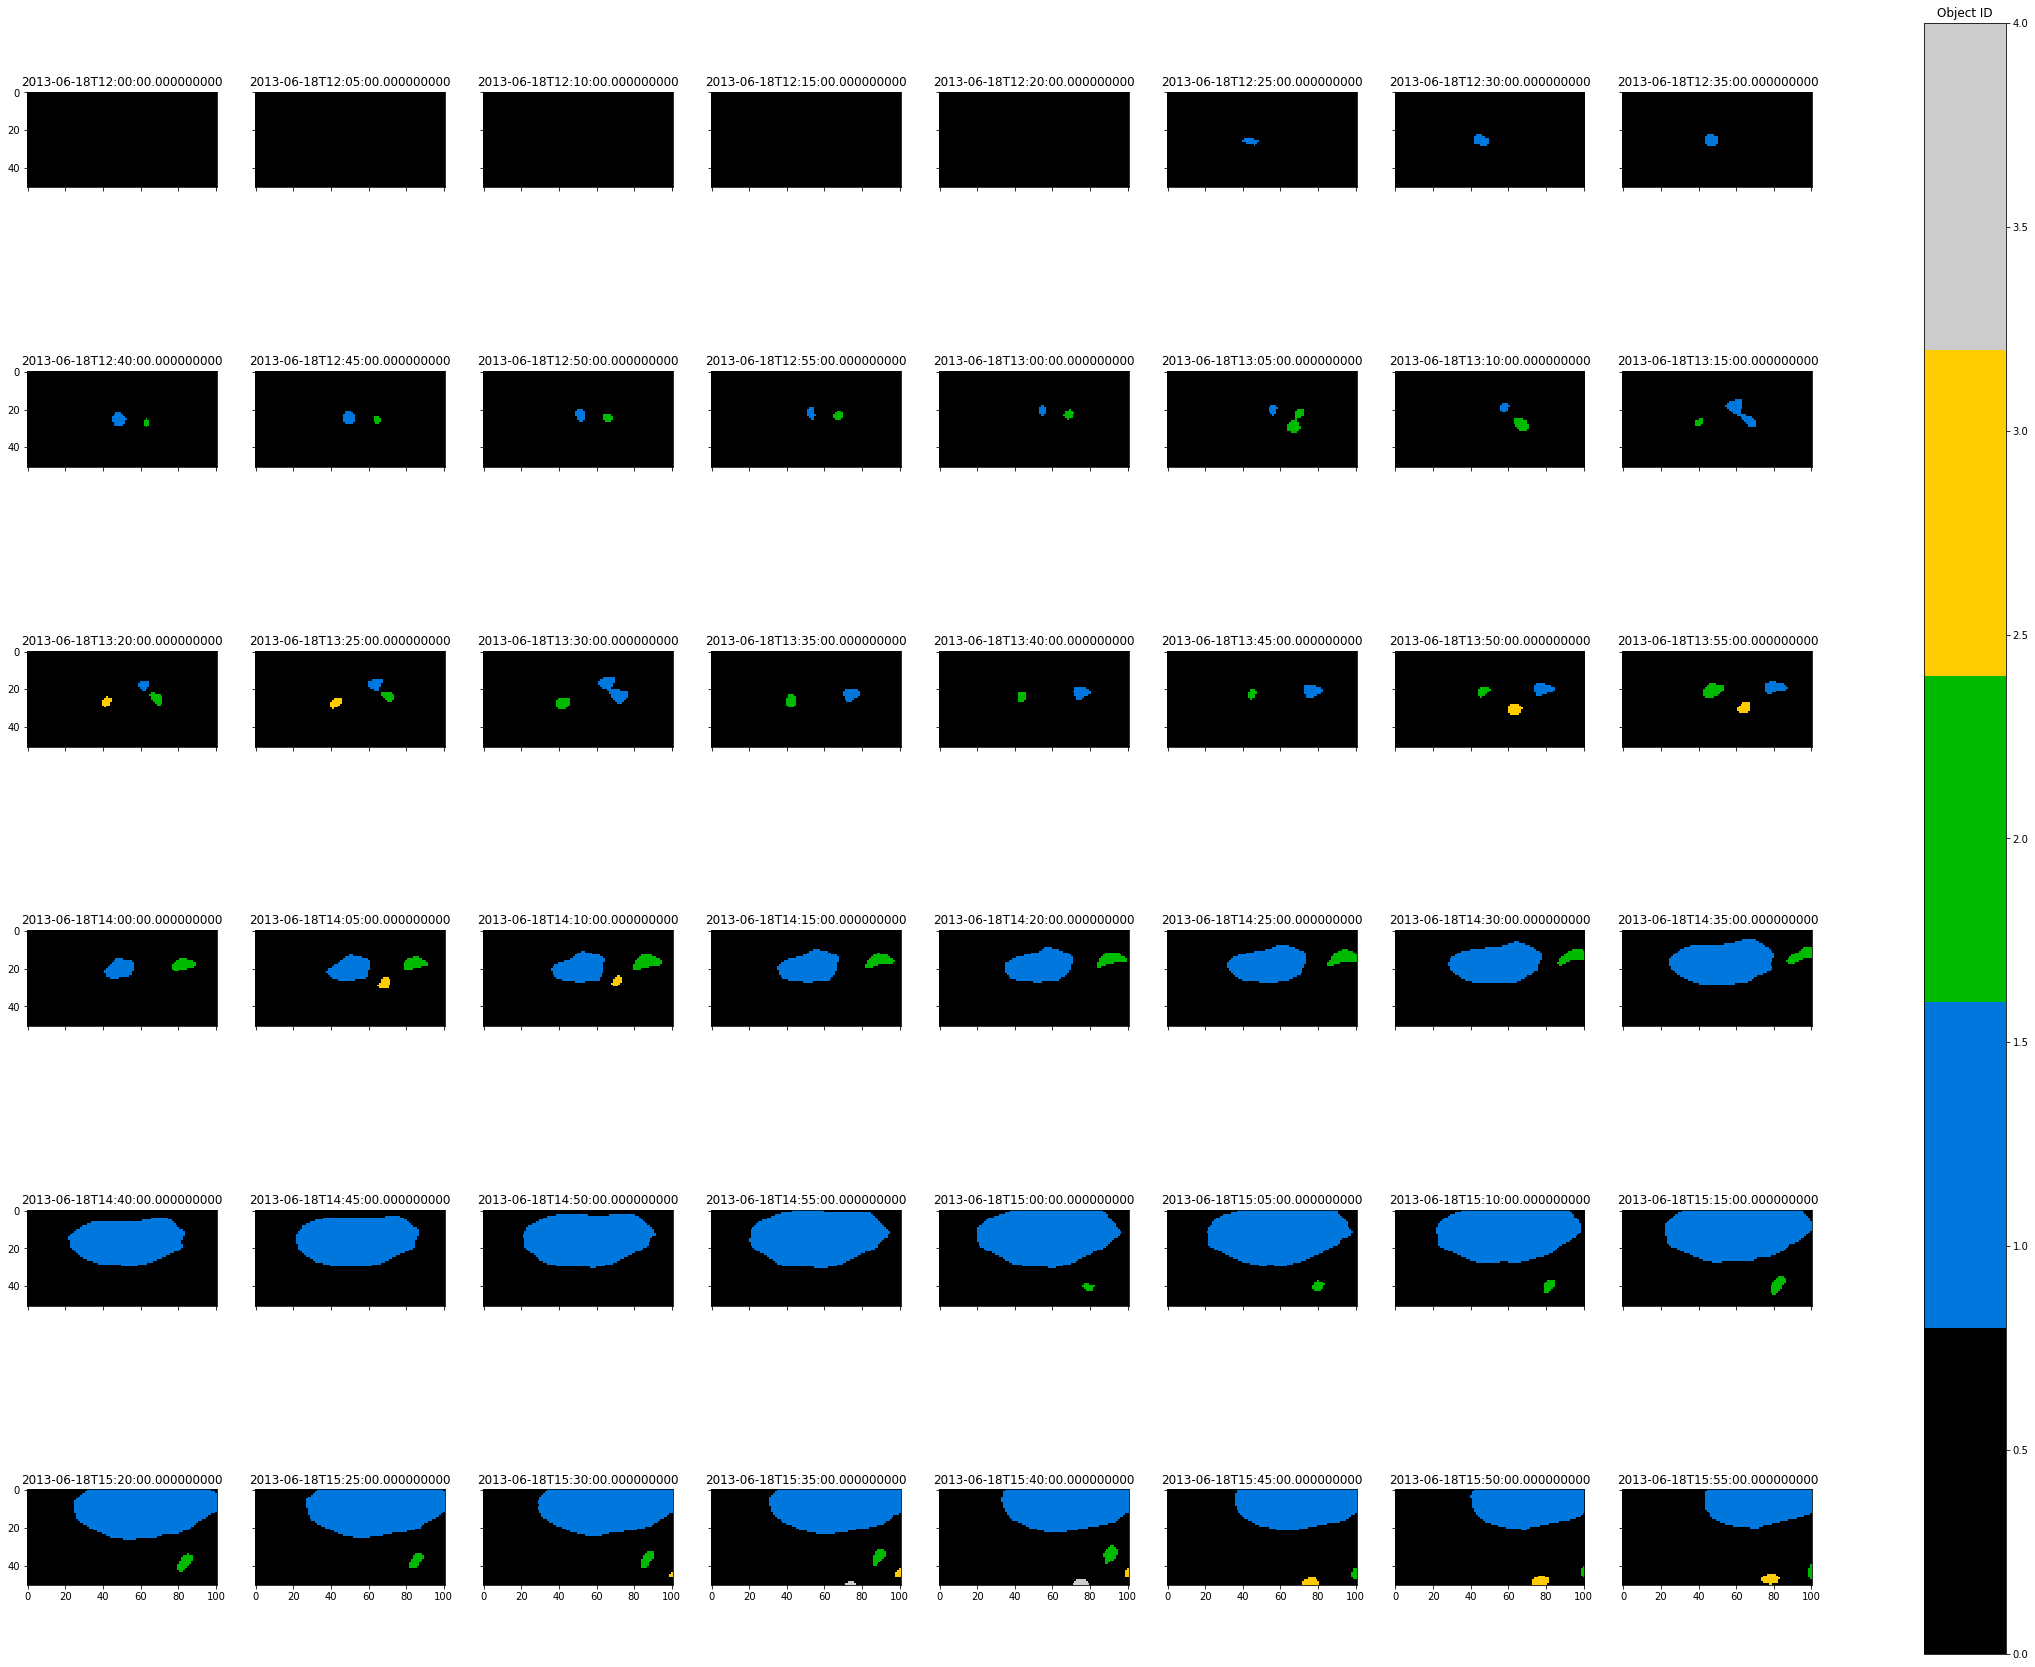

In [18]:
fig,ax = plt.subplots(6,8,figsize=(40,30),sharex=True,sharey=True)
axs = ax.ravel()

for i,s in enumerate(segmented):
    p = axs[i].imshow(s,vmin=0,vmax=4,cmap=cmap)
    axs[i].set_title(sat_data.time.data[i])
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'Object ID')

In [19]:
wanted_obj = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

In [20]:
len(wanted_obj)

48

In [21]:
len(sat_data.time.data)

48

In [22]:
wo = []

for i,s  in enumerate(segmented):
    wo.append(~np.ma.masked_not_equal(s,wanted_obj[i]).mask*1)

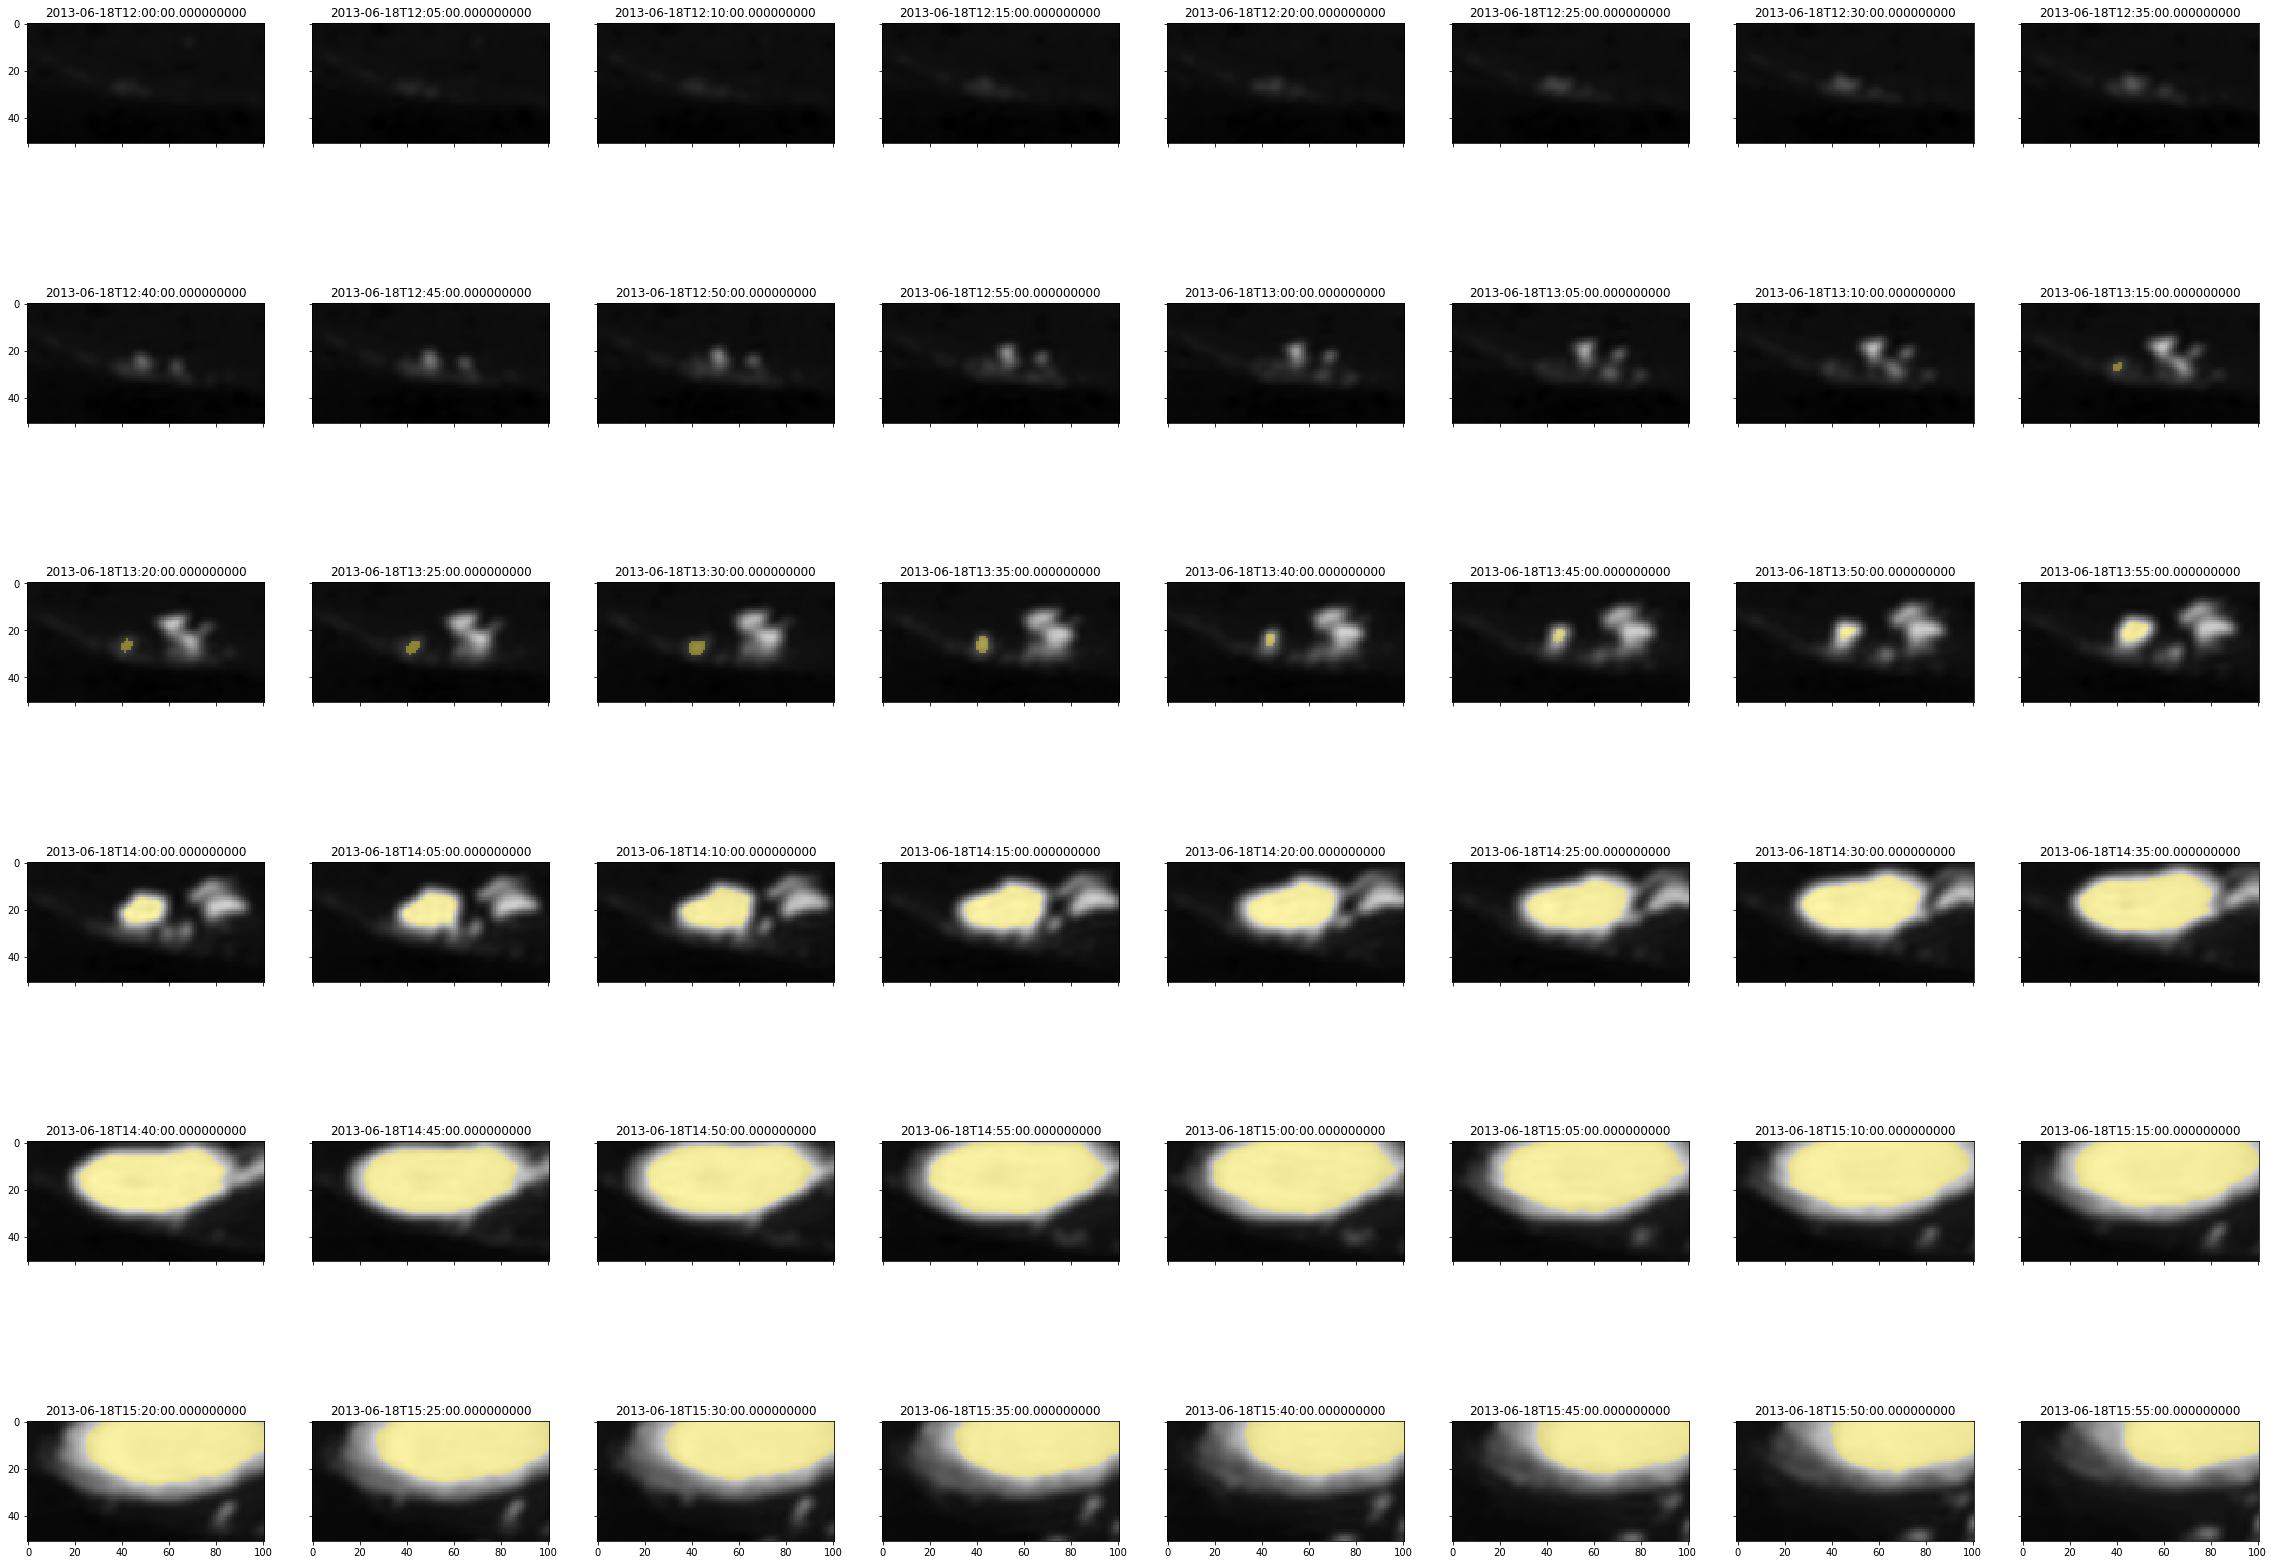

In [23]:
fig,ax = plt.subplots(6,8,figsize=(40,30),sharex=True,sharey=True)
axs = ax.ravel()

for i,s in enumerate(wo):
    axs[i].imshow(sat_data.ir108.data[i],vmin=210,vmax=300,cmap='gray_r')
    p = axs[i].imshow(np.ma.masked_less(s,1),vmin=0,vmax=1,cmap='viridis',alpha=0.4)
    axs[i].set_title(sat_data.time.data[i])

In [24]:
ds = xr.Dataset({'object_mask': (['time','x', 'y'],  np.array(wo,dtype='int'))},
                    
                   coords={'time': sat_data.time.data,
                           'lon': (['x', 'y'], sat_data.lon.data),
                           'lat': (['x', 'y'], sat_data.lat.data)})
ds.to_netcdf("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_mask.nc")
ds.close()

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/coding/times.py:244: FutureWarning: the 'box' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'box'
  dates = pd.to_datetime(dates, box=False)


In [25]:
ir108 = lsd.load_satellite_data(dt.datetime(2013,6,18,11,0),"IR_108")

Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [26]:
ir108_sm = ndi.gaussian_filter(ir108,1)

In [27]:
local_minima = h_minima(ir108_sm,10)

In [28]:
lm_labeled = ndi.label(local_minima)[0]

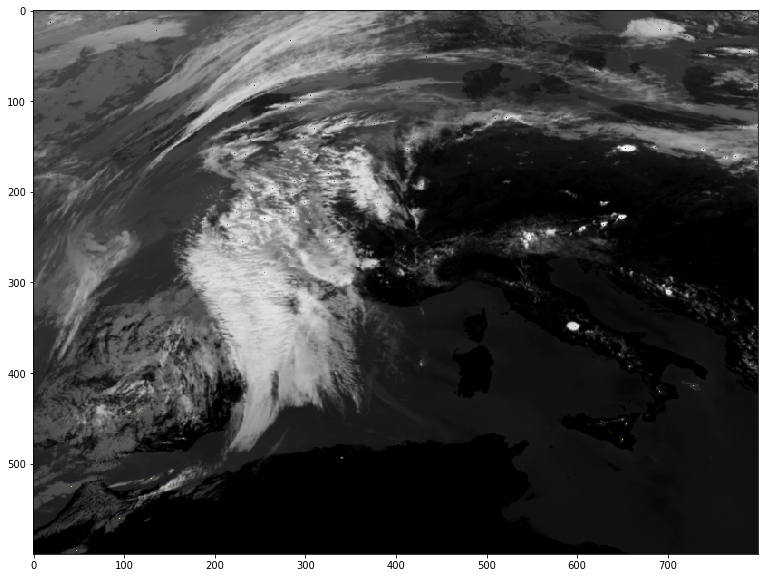

In [29]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(ir108,vmin=210,vmax=300,cmap='gray_r')
ax.imshow(np.ma.masked_less(lm_labeled,1))

In [30]:
minima_values = {i:[] for i in np.unique(lm_labeled)[1:]}
threshold_values  = {i:[] for i in np.unique(lm_labeled)[1:]}

In [31]:
for i,v in enumerate(np.unique(lm_labeled)[1:]):
    val = np.unique(ir108[np.where(lm_labeled==v)])
    minima_values[v] = val[0]
    
    thresh = get_mask_threshold(np.array([val]),280,10)
    threshold_values[v] = thresh

In [32]:
minima_values

{1: 243.3202454213567,
 2: 244.23381779932765,
 3: 260.63328193640496,
 4: 250.5259274321536,
 5: 236.29784674733287,
 6: 250.73344368914806,
 7: 253.77900751958433,
 8: 229.8408965620174,
 9: 242.62701495005595,
 10: 263.67808969547605,
 11: 261.7207597433242,
 12: 241.45572465462718,
 13: 228.40481466430967,
 14: 261.90061667731527,
 15: 230.12399712105722,
 16: 236.29784674733287,
 17: 248.20367254143252,
 18: 260.45062323186863,
 19: 245.13551683018653,
 20: 239.05001365664458,
 21: 224.80673238888176,
 22: 251.96652103001733,
 23: 230.12399712105722,
 24: 270.9264649461516,
 25: 226.3333364368797,
 26: 227.82044445079038,
 27: 255.93745203728983,
 28: 261.54050990083397,
 29: 244.0065543125907,
 30: 222.597601612772,
 31: 237.56333415487092,
 32: 240.0227576541142,
 33: 232.3421881036829,
 34: 229.55644719373979,
 35: 233.95460158226896,
 36: 239.05001365664458,
 37: 226.9327687735043,
 38: 233.68876314423764,
 39: 239.05001365664458,
 40: 244.23381779932765,
 41: 230.965371828515

In [33]:
threshold_values

{1: 253.3202454213567,
 2: 254.23381779932765,
 3: 270.63328193640496,
 4: 260.5259274321536,
 5: 246.29784674733287,
 6: 260.7334436891481,
 7: 263.7790075195843,
 8: 239.8408965620174,
 9: 252.62701495005595,
 10: 273.67808969547605,
 11: 271.7207597433242,
 12: 251.45572465462718,
 13: 238.40481466430967,
 14: 271.90061667731527,
 15: 240.12399712105722,
 16: 246.29784674733287,
 17: 258.2036725414325,
 18: 270.45062323186863,
 19: 255.13551683018653,
 20: 249.05001365664458,
 21: 234.80673238888176,
 22: 261.96652103001736,
 23: 240.12399712105722,
 24: 280.0,
 25: 236.3333364368797,
 26: 237.82044445079038,
 27: 265.93745203728986,
 28: 271.54050990083397,
 29: 254.0065543125907,
 30: 232.597601612772,
 31: 247.56333415487092,
 32: 250.0227576541142,
 33: 242.3421881036829,
 34: 239.55644719373979,
 35: 243.95460158226896,
 36: 249.05001365664458,
 37: 236.9327687735043,
 38: 243.68876314423764,
 39: 249.05001365664458,
 40: 254.23381779932765,
 41: 240.96537182851534,
 42: 255.58

In [34]:
segmented = np.zeros_like(ir108)

In [35]:
for l in np.unique(lm_labeled)[1:]:
    if np.isnan(threshold_values[l]):
        continue
    else:
        mask = np.ma.masked_greater(ir108,threshold_values[l])
        mask_labeled = ndi.label(~mask.mask*1)[0]
        lokmin_location = np.where(lm_labeled == l)
        wanted_obj_id = mask_labeled[lokmin_location]
        wanted_obj_location = np.where(mask_labeled==wanted_obj_id)
        segmented[wanted_obj_location] = l

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


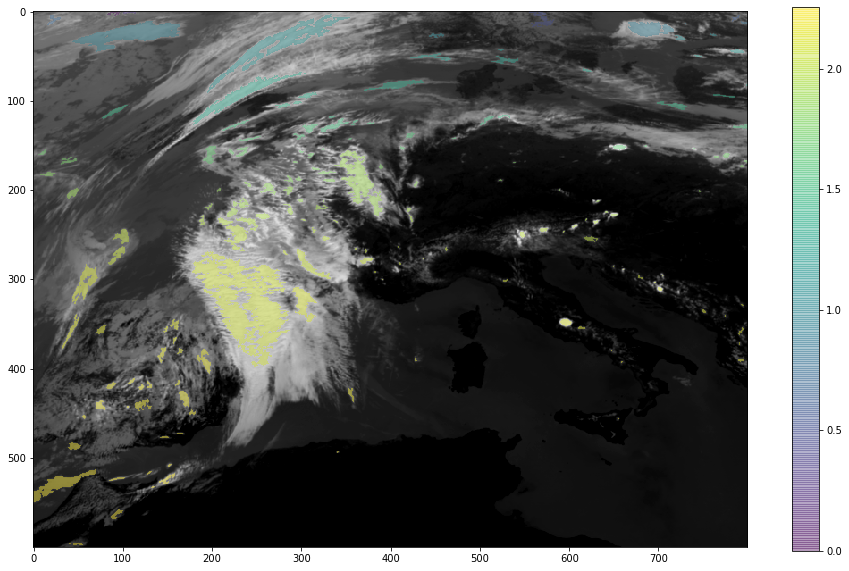

In [36]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(ir108,vmin=210,vmax=300,cmap='gray_r')
p = ax.imshow(np.log10(segmented),alpha=0.4)
plt.colorbar(p)

In [37]:
times = pd.date_range(start="20130618T1000",end="20130618T1600",freq="5min")

In [38]:
tstrings = [t.strftime("%Y%m%dT%H%M") for t in times]

In [39]:
sat_data = []

for t in times:
    ir108 = lsd.load_satellite_data(t.to_pydatetime(),"IR_108")
    sat_data.append(ir108)

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file
Region s

In [40]:
objects = []

for i, t in enumerate(times):
    obj = segment_local_minima(sat_data[i],10,275,10,1)
    objects.append(obj)
    
    fig,ax = plt.subplots(1,1,figsize=(16,10))
    ax.imshow(sat_data[i],vmin=210,vmax=300,cmap='gray_r')
    p = ax.imshow(np.ma.masked_less(obj,1),alpha=0.8)
    plt.colorbar(p)
    
    plt.savefig("/vols/satellite/home/lenk/pics/obj_test_{}.png".format(tstrings[i]))
    plt.close()

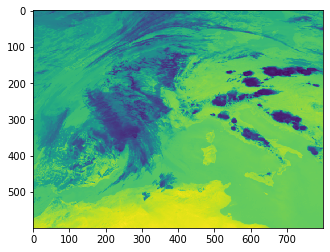

In [41]:
plt.imshow(sat_data[54])

In [42]:
ir108_sm = ndi.gaussian_filter(sat_data[54],1)

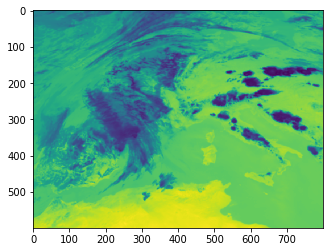

In [43]:
plt.imshow(ir108_sm)

In [44]:
local_minima = h_minima(ir108_sm,10)

In [45]:
lml = ndi.label(local_minima)[0]

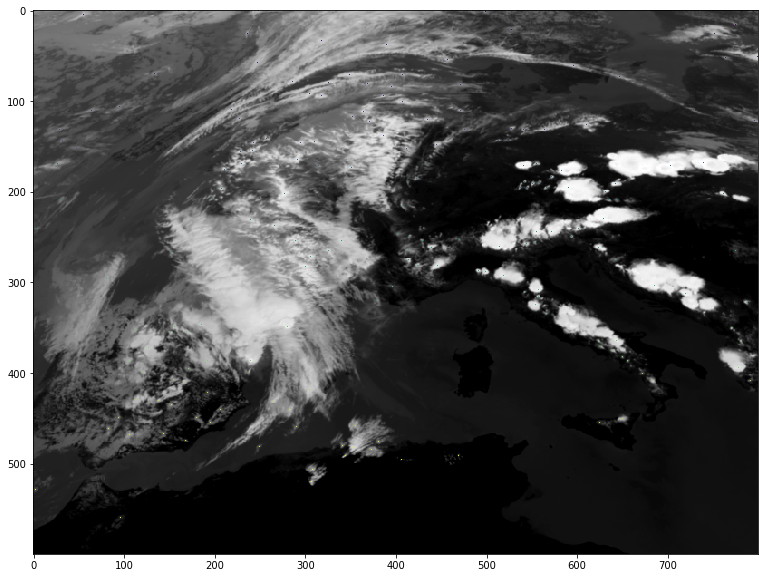

In [46]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(sat_data[54],vmin=210,vmax=300,cmap='gray_r')
ax.imshow(np.ma.masked_less(lml,1))

In [47]:
minima_values = {i:[] for i in np.unique(lm_labeled)[1:]}
threshold_values  = {i:[] for i in np.unique(lm_labeled)[1:]}

In [48]:
for i,v in enumerate(np.unique(lm_labeled)[1:]):
    val = np.unique(ir108[np.where(lm_labeled==v)])
    minima_values[v] = val[0]
    
    thresh = get_mask_threshold(np.array([val]),270,10)
    threshold_values[v] = thresh

In [49]:
minima_values

{1: 254.17597903443476,
 2: 259.7158597608433,
 3: 276.11635147420714,
 4: 283.4769703876239,
 5: 259.9001751380989,
 6: 264.2040570382616,
 7: 285.16525141630166,
 8: 278.9792167607633,
 9: 271.08813354813816,
 10: 260.45062323186863,
 11: 272.5303076834599,
 12: 265.7626598320494,
 13: 265.4187578382693,
 14: 256.8990841062822,
 15: 273.47925174039784,
 16: 280.0129068117795,
 17: 280.0129068117795,
 18: 283.4769703876239,
 19: 290.0710834452763,
 20: 288.19037516037866,
 21: 262.971639188704,
 22: 258.97436377837386,
 23: 256.5158456833914,
 24: 285.8605632228183,
 25: 265.59088148301174,
 26: 243.08994696468852,
 27: 289.0004707120896,
 28: 267.96521782804365,
 29: 247.77335600781245,
 30: 275.9632654805428,
 31: 286.8262082989984,
 32: 231.51984281029968,
 33: 281.3261203107329,
 34: 254.76761065935568,
 35: 250.94038028551697,
 36: 288.46109682452675,
 37: 257.2804661840967,
 38: 232.06930136793343,
 39: 241.45572465462718,
 40: 270.43970868135284,
 41: 245.80424609761,
 42: 260.

In [50]:
segmented = np.zeros_like(sat_data[54])

In [51]:
size = np.zeros_like(sat_data[54])

In [52]:
for l in np.unique(lm_labeled)[1:]:
    if np.isnan(threshold_values[l]):
        continue
    else:
        mask = np.ma.masked_greater(ir108,threshold_values[l])
        mask_labeled = ndi.label(~mask.mask*1)[0]
        lokmin_location = np.where(lm_labeled == l)
        wanted_obj_id = mask_labeled[lokmin_location]
        wanted_obj_location = np.where(mask_labeled==wanted_obj_id)
        print("{}: {}".format(l,len(wanted_obj_location[0])))
        segmented[wanted_obj_location] = l
        size[wanted_obj_location] = len(wanted_obj_location[0])

1: 7067
2: 10432
5: 10535
6: 369
10: 88245
12: 679
13: 88245
14: 80920
21: 88245
22: 86135
23: 75413
25: 88245
26: 1750
28: 427
29: 44760
32: 191
34: 71854
35: 63353
37: 81694
38: 308
39: 5783
41: 75
42: 88245
44: 7248
45: 3430
48: 88245
49: 88245
53: 88245
54: 4772
55: 4653
57: 4920
58: 88245
59: 410
60: 4822
61: 311
64: 214
65: 88245
66: 80920
67: 81694
69: 39586
71: 22094
72: 2247
73: 205
76: 1059
78: 767
82: 88245
84: 62824
87: 23705
88: 1063
89: 1185
90: 88245
91: 37087
93: 37549
94: 1079
95: 22491
96: 66461
97: 24101
98: 81316
99: 1327
100: 4597
101: 3931
102: 23269
103: 5414
104: 13
105: 22491
106: 221
107: 71590
110: 23546
113: 88245
114: 27619
115: 265
117: 22491
118: 80
119: 2473
120: 15432
121: 2473
123: 3154
124: 2381
127: 2515
128: 2671
129: 81316
130: 2597
131: 86426
135: 1186
136: 25328
137: 1288
140: 83234
141: 4803
142: 86426
144: 7
146: 11
151: 1000
153: 1972
154: 1972
155: 495
157: 1972
161: 1972
171: 1719


In [53]:
np.unique(segmented[np.where(size== np.max(size))])

array([113.])

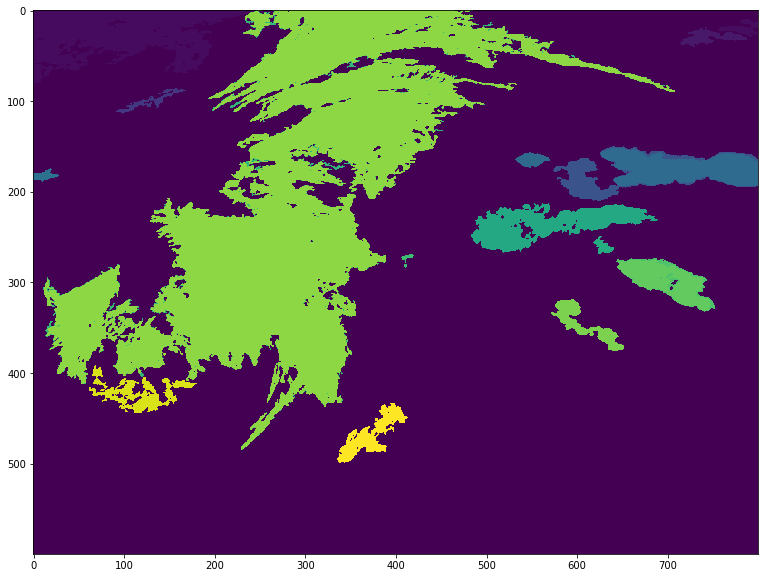

In [54]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(segmented)

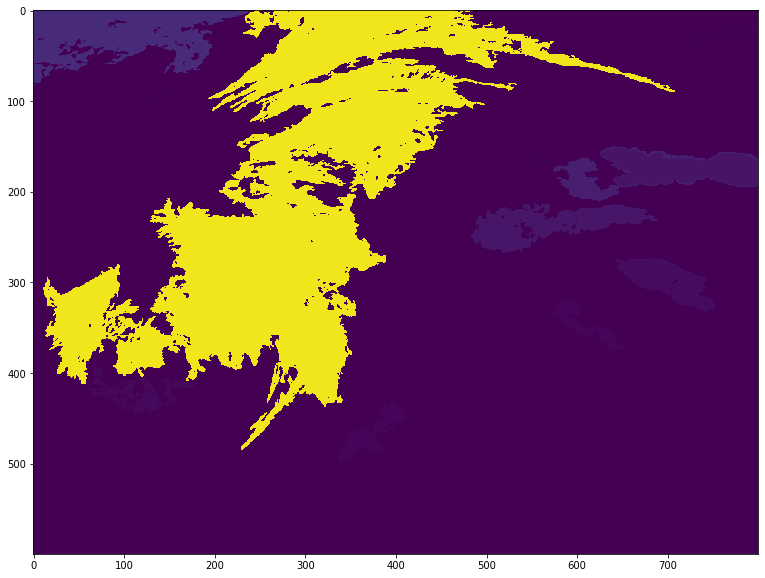

In [55]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(size)

In [56]:
tstrings = [t.strftime("%Y%m%dT%H%M") for t in times]

In [57]:
plt.switch_backend("Agg")

for i,o in enumerate(objects):
    fig,ax = plt.subplots(1,1,figsize=(16,10))
    ax.imshow(sat_data[i],vmin=210,vmax=300,cmap='gray_r')
    p = ax.imshow(np.ma.masked_less(o,1),alpha=0.8)
    plt.colorbar(p)
    
    plt.savefig("/vols/satellite/home/lenk/pics/obj_test_{}.png".format(tstrings[i]))
    plt.close()

In [58]:
from importlib import reload
reload(ot)

<module 'object_tracking' from '/vols/satellite/home/lenk/utils/tracking/object_tracking.py'>

In [59]:
connections,obj = ot.generate_graph_from_components(objects.copy(),
                                                    tstrings)

In [60]:
import networkx as nx

In [61]:
from networkx.drawing.nx_pydot import write_dot
import pydot

In [62]:
for i,o in enumerate(obj[1:]):
    nx.nx_pydot.write_dot(o, "/vols/satellite/home/lenk/graphs/20130618_obj_{:04d}.dot".format(i))

In [63]:
obj_mask = xr.open_dataset("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_mask.nc")

In [64]:
obj_mask.close()

In [65]:
cutout = xr.open_dataset("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/msg2-20130618-l15msg.nc")

In [66]:
om = []

for ir in cutout.ir108.data:
    om.append(segment_local_minima(ir,10,280,12,1))

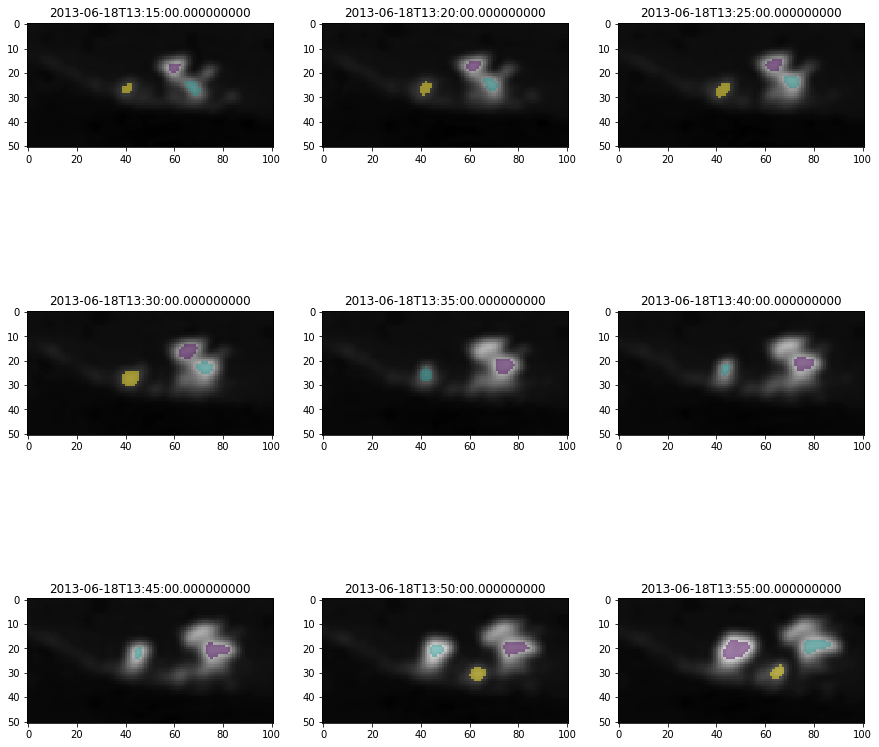

In [67]:
fig,ax = plt.subplots(3,3,figsize=(15,15))
axs = ax.ravel()

for i,o in enumerate(om[15:24]):
    axs[i].imshow(cutout.ir108.data[15:24][i],vmin=210,vmax=300,cmap='gray_r')
    axs[i].imshow(np.ma.masked_less(o,1),alpha=0.5,vmin=1,vmax=3)
    axs[i].set_title(cutout.time.data[15:24][i])

In [68]:
oids = [3,3,3,3,2,2,2,2,2]

In [69]:
obj_mask = []
ir_vals = []
times = []
var = []

for i,o in enumerate(om[15:24]):
    oo = np.zeros_like(o)
    
    o_loc = np.where(o==oids[i])
    oo[o_loc] = 1
    
    obj_mask.append(oo)
    
    ir_vals.extend(cutout.ir108.data[15:24][i][o_loc])
    
    t = pd.Timestamp(cutout.time.data[15:24][i]).strftime("%H:%M")
    times.extend([t]*len(o_loc[0]))
    var.extend(["IR 10.8 µm"]*len(o_loc[0]))

In [70]:
data_df = pd.DataFrame({'values':ir_vals,
                        'time':times,
                        'variable':var})

In [71]:
import seaborn as sns

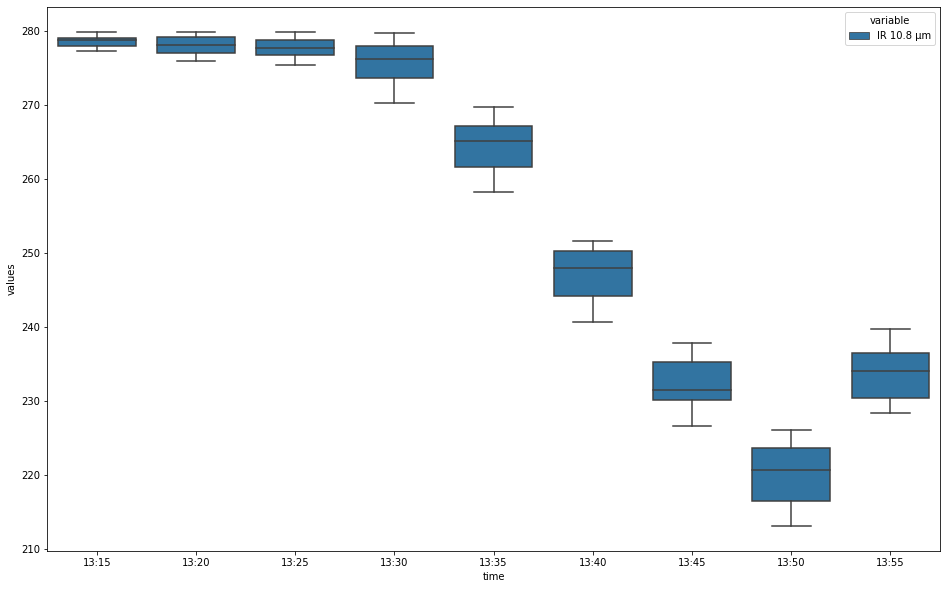

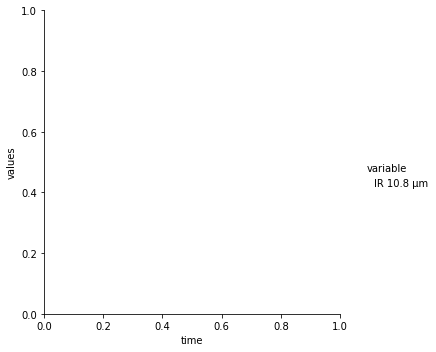

In [72]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
sns.catplot(x='time',y='values',hue='variable',kind='box',ax=ax,data=data_df)

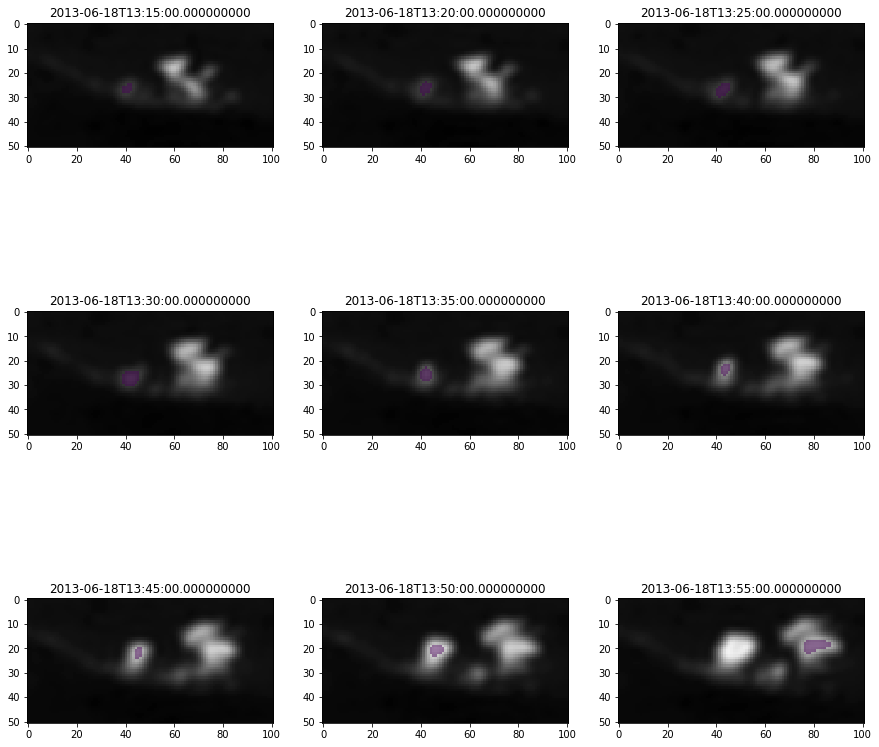

In [73]:
fig,ax = plt.subplots(3,3,figsize=(15,15))
axs = ax.ravel()

for i,o in enumerate(obj_mask):
    axs[i].imshow(cutout.ir108.data[15:24][i],vmin=210,vmax=300,cmap='gray_r')
    axs[i].imshow(np.ma.masked_less(o,1),alpha=0.5,vmin=1,vmax=3)
    axs[i].set_title(cutout.time.data[15:24][i])

In [74]:
object_mask.close()

NameError: name 'object_mask' is not defined

In [ ]:
ds = xr.Dataset({'object_mask': (['time','x', 'y'],  np.array(obj_mask,dtype='int'))},
                    
                   coords={'time': cutout.time.data[15:24],
                           'lon': (['x', 'y'], cutout.lon.data),
                           'lat': (['x', 'y'], cutout.lat.data)})
ds.to_netcdf("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_mask.nc")
ds.close()

## Ansatz nach Hartwigs Erläuterungen

Hartwigs Ansatz besteht aus zwei Teilen:

1. Lokale Minima finden und Ellipsen für das Tracking darum anlegen
2. Lokaler Schwellwert, um Objekte zu definieren

### 1. Lokale Minima und Ellipsen

Wir suchen uns zuerst die lokalen Minima einer bestimmten Tiefe. Um symmetrische Suchbereiche nutzen zu können, erhöhen wir die meridionale Auflösung um den Faktor zwei.

Als nächstes suchen wir uns die lokalen Minima.

In [2]:
from skimage.draw import ellipse

In [5]:
lmin = h_minima(sat_data.ir108.data[15].copy(),10)
lmin_l = ndi.label(lmin)[0]

Und erzeugen die Ellipsen um sie herum.

In [6]:
def get_labeled_local_minima(field,minimum_depth=10):
    minima = h_minima(field,minimum_depth)
    
    return ndi.label(minima)[0]

In [7]:
def get_track_ellipses(field,elipsis_width=5,elipsis_height=9,elipsis_rotation=0):
    ellipses_field = np.zeros_like(field, dtype="uint8")
    
    # check if field is labeled, if not, label it
    if np.max(field) == 1:
        field = ndi.label(field)[0]
    
    for l in np.unique(field):
        min_loc = np.where(field == l)
    
        rr, cc = ellipse(min_loc[0][0],
                         min_loc[1][0],
                         elipsis_width, 
                         elipsis_height, 
                         rotation=elipsis_rotation)
        
        rr = np.clip(rr,0,field.shape[0]-1)
        cc = np.clip(cc,0,field.shape[1]-1)
        ellipses_field[rr,cc] = l
    
    ellipses_field = ~np.ma.masked_less(ellipses_field,1).mask*1
    return ellipses_field   

In [8]:
test = get_track_ellipses(lmin_l)

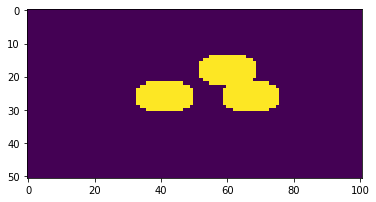

In [9]:
plt.imshow(test)

In [10]:
lm = np.zeros_like(lmin, dtype="uint8")

for l in np.unique(lmin_l):
    min_loc = np.where(lmin_l == l)
    
    rr, cc = ellipse(min_loc[0][0], min_loc[1][0], 5, 9, rotation=0)
    lm[rr,cc] = l

Text(0.5, 1.0, 'lokale Minima mit Ellipsen')

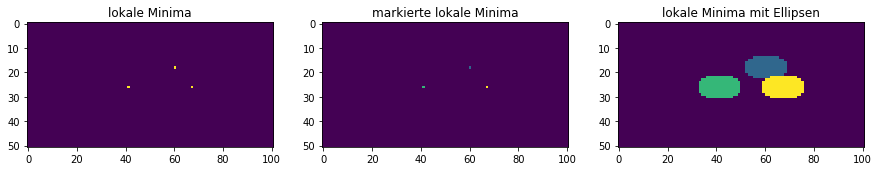

In [11]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(lmin)
ax[0].set_title(u"lokale Minima")
ax[1].imshow(lmin_l)
ax[1].set_title(u"markierte lokale Minima")
ax[2].imshow(lm)
ax[2].set_title(u"lokale Minima mit Ellipsen")

In [12]:
locmin  = np.zeros((9,51,101))
omask   = np.zeros((9,51,101))
k = np.arange(0,9)
t0 = 15

In [13]:
for i in k:
    bt = sat_data.ir108.data[t0 + i].copy()
    lm_l = get_labeled_local_minima(bt,10)
    
    locmin[i,:,:] = get_track_ellipses(lm_l)

Text(0.5, 1.0, 'Ellipsen')

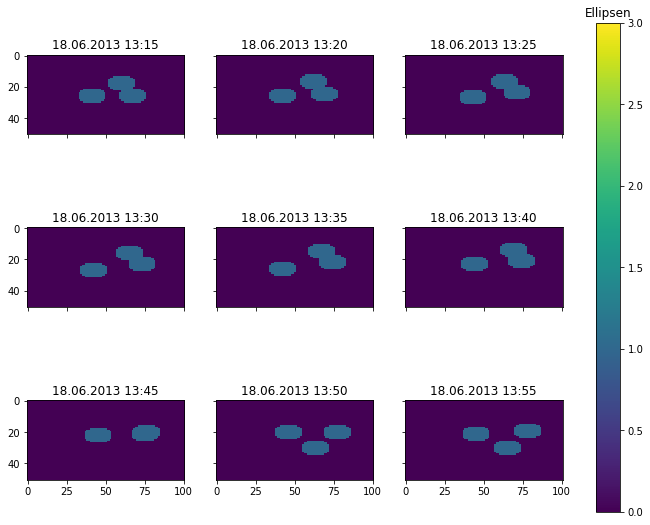

In [14]:
fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,lm in enumerate(locmin):
   
    p = axs[i].imshow(lm,vmin=0,vmax=3)

    axs[i].set_title(pd.Timestamp(sat_data.time.data[t0 + i]).strftime("%d.%m.%Y %H:%M"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'Ellipsen')

In [15]:
obj  = ndi.label(locmin)[0]

Text(0.5, 1.0, 'Object location')

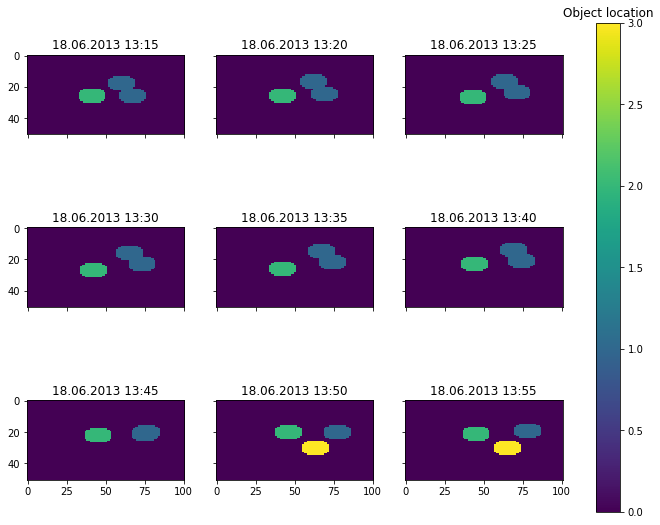

In [16]:
fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,lm in enumerate(obj):
   
    p = axs[i].imshow(lm,vmin=0,vmax=np.max(np.unique(obj)))

    axs[i].set_title(pd.Timestamp(sat_data.time.data[t0 + i]).strftime("%d.%m.%Y %H:%M"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'Object location')

In [ ]:
omask = obj== 2

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,lm in enumerate(omask):
   
    p = axs[i].imshow(lm,vmin=0,vmax=3)

    axs[i].set_title(pd.Timestamp(sat_data.time.data[t0 + i]).strftime("%d.%m.%Y %H:%M"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'Object mask')

In [ ]:
def local_threshold(T, Tmax=273.15, thresh_min=240, Tmin=220, spread=5):
    T_thresh = np.max((T + spread, T + spread + 15*(T - Tmax)/ (Tmin - Tmax),thresh_min))
    return T_thresh

In [ ]:
test = [lsd.load_satellite_data(d,"IR_108") for d in [dt.datetime(2013,6,18,11,50),
                                                      dt.datetime(2013,6,18,11,55),
                                                      dt.datetime(2013,6,18,12,0)]]

In [ ]:
lmin = [get_labeled_local_minima(t,10) for t in test]

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(test,vmin=210,vmax=300,cmap='gray_r')
ax.imshow(np.ma.masked_less(lmin,1),cmap='nipy_spectral')

In [ ]:
locmin = np.zeros((3,600,800))

In [ ]:
omask = np.zeros((3,600,800))

In [ ]:
for i,l in enumerate(lmin):
    locmin[i,:,:] = get_track_ellipses(l)

In [ ]:
plt.imshow(locmin)

In [ ]:
obj = ndi.label(locmin)[0]

In [ ]:
plt.imshow(obj[2])

In [ ]:
omask = obj ==150

In [ ]:
omask

In [ ]:
plt.imshow(omask[2])

In [ ]:
tmin = np.min(test[0][omask[0]])

In [ ]:
tmin

In [ ]:
thresh = local_threshold(tmin,273.15,240,5)

In [ ]:
thresh

In [ ]:
om = ~np.ma.masked_less(obj,1).mask*1

In [ ]:
min_map = np.zeros((3,600,800))
thr_map = np.zeros((3,600,800))

In [ ]:
for i in [0,1,2]:
    for l in np.unique(obj[i])[1:]:
        oloc = np.where(obj[i]==l)
        tmin = np.min(test[i][oloc])
    
        thresh = local_threshold(tmin,273.15,240,5)
    
        thr_map[i][oloc] = thresh
        min_map[i][oloc] = tmin

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
p0 = ax[0].imshow(np.ma.masked_less(thr_map[0],1),vmin=210,vmax=300,cmap=emap)
fc.colourbar(p0)
p1= ax[1].imshow(np.ma.masked_less(min_map[0],1),vmin=210,vmax=300,cmap=emap)
fc.colourbar(p1)

In [ ]:
omask_bt = np.zeros((9,600,800),dtype=np.bool)

In [ ]:
mthresh = test[0]<thresh
lthresh = ndi.label(mthresh)[0]
ll = lthresh[omask[0]]
ll = ll[ll>0]
ll = ll[0]
omask_bt[0,:,:] = lthresh==ll

In [ ]:
plt.imshow(omask_bt[0])
plt.xlim(700,720)
plt.ylim(400,420)

In [ ]:
mxt = 273.15

In [ ]:
omask_bt_240_05 = np.zeros((9,51,101),dtype=np.bool)
omask_bt_240_07 = np.zeros((9,51,101),dtype=np.bool)
omask_bt_230_05 = np.zeros((9,51,101),dtype=np.bool)
omask_bt_230_07 = np.zeros((9,51,101),dtype=np.bool)
for i in k:
    #im   = np.repeat(sat_data.ir108.data[i+t0].copy(),2,axis=0)
    im   = sat_data.ir108.data[i+t0].copy()
    print("\ntime: ", pd.Timestamp(sat_data.time.data[i+t0]).strftime("%d.%m.%Y %H:%M"))
    tmin = np.min(im[omask[i]])
    print("MinBT: ",tmin)
    #Tthresh =  np.max((tmin+5,tmin+5.0+15.0*(tmin-273.15)/(220.0-273.15),240.0))
    #Tthresh =  np.max((tmin+7.0,tmin+7.0+15.0*(tmin-mxt)/(220.0-mxt),240.0))
    Tthresh_240_05 = local_threshold(tmin,mxt,240,5)
    Tthresh_240_07 = local_threshold(tmin,mxt,240,7)
    Tthresh_230_05 = local_threshold(tmin,mxt,230,5)
    Tthresh_230_07 = local_threshold(tmin,mxt,230,7)
    
    print("Thresh(240K, 5K):  ",Tthresh_240_05)
    print("Thresh(240K, 7K):  ",Tthresh_240_07)
    print("Thresh(230K, 5K):  ",Tthresh_230_05)
    print("Thresh(230K, 7K):  ",Tthresh_230_07)
    
    mthresh_240_05 = im<Tthresh_240_05
    lthresh = ndi.label(mthresh_240_05)[0]
    ll = lthresh[omask[i]]
    ll = ll[ll>0]
    ll = ll[0]
    omask_bt_240_05[i,:,:] = lthresh==ll
    
    mthresh_240_07 = im<Tthresh_240_07
    lthresh = ndi.label(mthresh_240_07)[0]
    ll = lthresh[omask[i]]
    ll = ll[ll>0]
    ll = ll[0]
    omask_bt_240_07[i,:,:] = lthresh==ll
    
    mthresh_230_05 = im<Tthresh_230_05
    lthresh = ndi.label(mthresh_230_05)[0]
    ll = lthresh[omask[i]]
    ll = ll[ll>0]
    ll = ll[0]
    omask_bt_230_05[i,:,:] = lthresh==ll
    
    mthresh_230_07 = im<Tthresh_230_07
    lthresh = ndi.label(mthresh_230_07)[0]
    ll = lthresh[omask[i]]
    ll = ll[ll>0]
    ll = ll[0]
    omask_bt_230_07[i,:,:] = lthresh==ll
    print("area: {}".format(np.sum(lthresh==ll)))

In [ ]:
bt = []
tidx = []
var = []

fig,ax = plt.subplots(3,3,figsize=(20,15),sharex=True,sharey=True)
axs=ax.ravel()

for i,lm in enumerate(omask_bt_240_05):
    p = axs[i].imshow(sat_data.ir108.data[t0+i],vmin=210,vmax=300,cmap='gray_r')
    #axs[i].imshow(np.ma.masked_less(lm,1),alpha=0.4, cmap = 'viridis_r')
    axs[i].contour(lm,[0,1],cmap='Reds_r',vmin=-0.3,vmax=1,alpha=0.4)
    axs[i].contour(omask_bt_240_07[i],[0,1],cmap='Oranges_r')#,vmin=-0.2,vmax=0.5,alpha=0.4)
    
    axs[i].contour(omask_bt_230_05[i],[0,1],cmap='Greens_r',vmin=-0.3,vmax=1,alpha=0.4)
    axs[i].contour(omask_bt_230_07[i],[0,1],cmap='Blues_r',vmin=-0.2,vmax=0.5,alpha=0.4)

    axs[i].set_title(pd.Timestamp(sat_data.time.data[t0 + i]).strftime("%d.%m.%Y %H:%M"))
    
    #sd = sat_data.ir108.data[t0+i].repeat(2,axis=0)[np.where(lm==1)]
    #bt.extend(sd)
    #tidx.extend([pd.Timestamp(sat_data.time.data[t0+i]).strftime("%H:%M")]*len(sd))
    #var.extend(['ir108']*len(sd))
    
    axs[i].set_xlim(35,60)
    axs[i].set_ylim(10,35)
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'BT(10.8 µm)')

In [ ]:
ds = xr.Dataset({'object_mask_240_05': (['time','x', 'y'],  np.array(omask_bt_240_05,dtype='uint8')),
                 'object_mask_240_07': (['time','x', 'y'],  np.array(omask_bt_240_07,dtype='uint8')),
                 'object_mask_230_05': (['time','x', 'y'],  np.array(omask_bt_230_05,dtype='uint8')),
                 'object_mask_230_07': (['time','x', 'y'],  np.array(omask_bt_230_07,dtype='uint8'))},
                    
                   coords={'time': sat_data.time.data[15:24],
                           'lon': (['x', 'y'], sat_data.lon.data),
                           'lat': (['x', 'y'], sat_data.lat.data)})
ds.to_netcdf("/vols/satellite/home/lenk/proj/2019-12_HRV-Paper/object_mask.nc")
ds.close()

In [ ]:
test_df = pd.DataFrame({'value':bt,'time':tidx})

In [ ]:
test_df.head()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax = sns.catplot(x='time',y='value',data=test_df,kind='box',ax=ax)

In [ ]:
T = np.arange(280,179,-1)

In [ ]:
threshs = np.arange(260,220,-10)
spreads = np.arange(5,25,5)

In [ ]:
spreads

In [ ]:
threshold = {t:{s:[] for s in spreads} for t in threshs}

In [ ]:
for t in threshs:
    for s in spreads:
        threshold[t][s] = [local_threshold(tm,273.15, t, s) for tm in T]

In [ ]:
line_colour = {260:'#ff0000ff',
               250:'orange',
               240:'yellow',
               230:'green',
               220:'blue'}
lstyle = {5:':',
          10:'-.',
          15:'--',
          20:'-'}

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,16))
for t in threshs:
    for s in spreads:
        ax.plot(T,threshold[t][s],c=line_colour[t],linestyle=lstyle[s])
ax.plot(T,T,c='k')
ax.set_xlim(280,190)

Als nächstes suchen wir uns die lokalen Minima.

In [ ]:
lmin = h_minima(sat_data.ir108.data[15].copy(),10)
lmin_l = ndi.label(lmin)[0]

Und erzeugen die Ellipsen um sie herum.

In [ ]:
lm = np.zeros_like(lmin, dtype="uint8")

for l in np.unique(lmin_l):
    min_loc = np.where(lmin_l == l)
    
    rr, cc = ellipse(min_loc[0][0], min_loc[1][0], 5, 9, rotation=0)
    lm[rr,cc] = l

In [ ]:
rr,cc

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(lmin)
ax[0].set_title(u"lokale Minima")
ax[1].imshow(lmin_l)
ax[1].set_title(u"markierte lokale Minima")
ax[2].imshow(lm)
ax[2].set_title(u"lokale Minima mit Ellipsen")

In [ ]:
locmin  = np.zeros((9,102,101))
omask   = np.zeros((9,102,101))
k = np.arange(0,9)
t0 = 15

In [ ]:
for i in k:
    bt = sat_data.ir108.data[t0 + i].copy()
    lm = h_minima(bt,10)
    lm_l = ndi.label(lm)[0]
    
    lm = np.zeros_like(lm, dtype="uint8")
    
    for l in np.unique(lm_l)[1:]:
        min_loc = np.where(lm_l == l)
        lm_loc = ellipse(min_loc[0][0], min_loc[1][0], 5, 9, rotation=0)
        lm[lm_loc] = 1
    
    locmin[i,:,:] = lm.repeat(2,axis=0)

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,lm in enumerate(locmin):
   
    p = axs[i].imshow(lm,vmin=0,vmax=3)

    axs[i].set_title(pd.Timestamp(sat_data.time.data[t0 + i]).strftime("%d.%m.%Y %H:%M"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'Ellipses')

In [ ]:
obj  = ndi.label(locmin)[0]

In [ ]:
np.unique(obj)

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,lm in enumerate(obj):
   
    p = axs[i].imshow(lm,vmin=0,vmax=3)

    axs[i].set_title(pd.Timestamp(sat_data.time.data[t0 + i]).strftime("%d.%m.%Y %H:%M"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'Object location')

In [ ]:
omask = obj== 2

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,lm in enumerate(omask):
   
    p = axs[i].imshow(lm,vmin=0,vmax=3)

    axs[i].set_title(pd.Timestamp(sat_data.time.data[t0 + i]).strftime("%d.%m.%Y %H:%M"))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'Object mask')

In [ ]:
def local_threshold(tmin, tmax, thresh_min, spread):
    T_thresh = np.max((tmin + spread, tmin + spread + 15*(tmin - tmax)/ (220 - tmax),thresh_min))
    return T_thresh

In [ ]:
mxt = 273.15

In [ ]:
omask_bt = np.zeros((9,102,101),dtype=np.bool)
for i in k:
    im   = np.repeat(sat_data.ir108.data[i+t0].copy(),2,axis=0)
    print("\ntime: ", pd.Timestamp(sat_data.time.data[i+t0]).strftime("%d.%m.%Y %H:%M"))
    tmin = np.min(im[omask[i]])
    print("MinBT: ",tmin)
    Tthresh =  np.max((tmin+5,tmin+5.0+15.0*(tmin-273.15)/(220.0-273.15),240.0))
    print("Thresh:  ",Tthresh)
    mthresh = im<Tthresh
    lthresh = ndi.label(mthresh)[0]
    ll = lthresh[omask[i]]
    ll = ll[ll>0]
    ll = ll[0]
    omask_bt[i,:,:] = lthresh==ll
    print("area: {}".format(np.sum(lthresh==ll)))

In [ ]:
bt = []
tidx = []
var = []

fig,ax = plt.subplots(3,3,figsize=(12,9),sharex=True,sharey=True)
axs=ax.ravel()

for i,lm in enumerate(omask_bt):
    p = axs[i].imshow(sat_data.ir108.data[t0+i].repeat(2,axis=0),vmin=210,vmax=300,cmap='gray_r')
    axs[i].imshow(np.ma.masked_less(lm,1),alpha=0.4, cmap = 'viridis_r')

    axs[i].set_title(pd.Timestamp(sat_data.time.data[t0 + i]).strftime("%d.%m.%Y %H:%M"))
    
    sd = sat_data.ir108.data[t0+i].repeat(2,axis=0)[np.where(lm==1)]
    bt.extend(sd)
    tidx.extend([pd.Timestamp(sat_data.time.data[t0+i]).strftime("%H:%M")]*len(sd))
    var.extend(['ir108']*len(sd))
    
cbar = fig.colorbar(p, ax=ax.flat)
cbar.ax.set_title(u'BT(10.8 µm)')

In [ ]:
test_df = pd.DataFrame({'value':bt,'time':tidx})

In [ ]:
test_df.head()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax = sns.catplot(x='time',y='value',data=test_df,kind='box',ax=ax)

In [ ]:
T = np.arange(290,179,-1)

In [ ]:
threshs = np.arange(240,220,-10)
spreads = [5,7]

In [ ]:
spreads

In [ ]:
threshold = {t:{s:[] for s in spreads} for t in threshs}

In [ ]:
for t in threshs:
    for s in spreads:
        threshold[t][s] = [local_threshold(tm,273.15, t, s) for tm in T]

In [ ]:
line_colour = {5:'#ff0000aa',
               7:'#0000ffaa'}
lstyle = {240:':',
          230:'--'}

In [ ]:
thresh_label = ["{} K".format(t) for t in threshs]
spread_label = ["{} K".format(s) for s in [5,7]]

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
for t in threshs:
    for s in spreads:
        ax.plot(T,threshold[t][s],c=line_colour[s],linestyle=lstyle[t])
ax.plot(T,T,c='k')
ax.set_xlim(290,190)
ax.set_xlabel("Tmin / K")
ax.set_ylabel("Tthresh. / K")

# create legends
dummy_lines = []
for t_idx, t in enumerate(threshold):
    dummy_lines.append(ax.plot([],[], c="black", ls = lstyle[t])[0])
lines = ax.get_lines()

legend1 = plt.legend([lines[i] for i,s in enumerate(spreads)], 
                     spread_label, 
                     loc="center left",
                     title="Spread",
                     bbox_to_anchor=(1, 0.5))

legend2 = plt.legend([dummy_lines[i] for i,t in enumerate(threshold)],
                     thresh_label,
                     loc="upper center",
                     title="leveling thresholds",
                     bbox_to_anchor=(0.5, -0.08),
                     ncol=2)
ax.add_artist(legend1)

In [ ]:
lines[0]